---
title: "Code Contribution and Authorship"
author:
  - name: "Eva Maxfield Brown"
    email: evamxb@uw.edu
    orcid: 0000-0003-2564-0373
    affliation:
      name: University of Washington Information School
      city: Seattle
      state: Washington
      country: USA
  - name: "Nicholas Weber"
    email: nmweber@uw.edu
    orcid: 0000-0002-6008-3763
    affliation:
      name: University of Washington Information School
      city: Seattle
      state: Washington
      country: USA

abstract: |
  Lorem ipsum dolor sit amet, consectetur adipiscing elit. Curabitur eget porta erat. Morbi consectetur est vel gravida pretium. Suspendisse ut dui eu ante cursus gravida non sed sem. Nullam sapien tellus, commodo id velit id, eleifend volutpat quam. Phasellus mauris velit, dapibus finibus elementum vel, pulvinar non tellus. Nunc pellentesque pretium diam, quis maximus dolor faucibus id. Nunc convallis sodales ante, ut ullamcorper est egestas vitae. Nam sit amet enim ultrices, ultrices elit pulvinar, volutpat risus.

## Basics
bibliography: main.bib

## Number sections (required for section cross ref)
number-sections: true

## Citation Style Language
# See https://github.com/citation-style-language/styles for more options
# We default to PNAS (Proceedings of the National Academy of Sciences)
# csl: support/acm-proceedings.csl

## Specific for target format
format:
  html:
    code-tools: true
    code-fold: true
    code-summary: "Show the code"
    standalone: true
    embed-resources: true
    toc: true
    toc-location: left
    reference-location: margin
    citation-location: margin

  pdf:
    toc: false
    execute:
      echo: false
    include-in-header:  
      - text: |
          \usepackage{multirow}

---

# Introduction

In [1]:
from pathlib import Path

import IPython.display
import pandas as pd
import statsmodels.api as sm
from sci_soft_models.dev_author_em.data import load_annotated_dev_author_em_dataset
from sqlalchemy import text
from sqlmodel import create_engine

from rs_graph.db import models as db_models

# Get db engine for production database
db_path = Path("rs-graph-temp.db").resolve().absolute()
db_conn = create_engine(f"sqlite:///{db_path}")

- Contemporary scientific research has become increasingly dependent on specialized software tools and computational methods.
  - define scientific software (scripts, tools, infrastructure)
  - importance in enabling large scale experiments and acting as a direct log of processing and analysis
  - scientific code sharing is on the rise

- Despite increased reliance on computational methodologies, the developers of scientific software have historically not been given traditional academic credit for their work: authorship on research articles.
  - qualitative research which talks about acknowledgements sections instead of authorship
  - lack of authorship can affect career prospects

- While new credit systems aim to be more inclusive towards more contribution types, they still suffer from two key problems.
	- Contributor Roles Taxonomy (CRediT) allows for specific “software” contribution
  - Others have used CREDIT to understand distribution of labor…
	- they are still based around an author list (it’s hard to change existing human practices, especially biased ones)
	- they aren’t verifiable, they are self-reported

- To address these problems, we create a novel predictive model that enables matching scientific article authors and source code developer accounts.
	- a predictive model is the best choice for entity matching because while authors have ORCIDs, developer accounts do not***
	- further, developer account information may be slightly different from publication information (preferred name / legal name), username’s, etc
	- a fine-tuned transformer model enables us to connect accounts which have similar enough information, hopefully providing us with many more author-code-contributor matches than would be possible on exact name or email address matching alone

- Our predictive model serves two primary purposes: identifying authors who directly contribute to an article’s associated codebase, and, revealing developers who were not included on the article’s authorship list.
	- while predictive, it is grounded in the commit logs of source code repositories, no longer self reported
	- individuals who have been left off can at least for now be identified by their developer account

- Further, by applying our model across a large corpora of paired research articles and source code repositories, we enable objective insight into the software development dynamics of research teams.
	- much like studies of CRediT, we can investigate both how many article authors contribute code
	- similarly, we can investigate who contributes code (by author position and external characteristics
	- again, this is via commit logs and contribution histories, rather than self-reported data

- To summarize, this paper makes the following contributions:
	- we train, evaluate, and make publicly available a predictive model to match article authors with developer accounts together
	- we create a large dataset of linked articles and source code repositories with accompanying bibliometric and repository information, and, further match article authors with repository developers
	- demonstration of the value of our predictive model through preliminary analysis of research team software development dynamics and code contributor characteristics

- The rest of this paper is organized as follows:
	- …

# Data and Methods

## Linking Scientific Articles and Associated Source Code Repositories

- Our trained predictive model and our preliminary analyses are based on datasets of linked bibliographic and source code repository information from multiple journals and publication platforms.
	- Each data source (the journals and publication platforms) either requires or recommends the sharing of code repositories related to a piece of work at the time of publication.
	- In turn, this allows us to mine article information for their either required, or recommended “data or code availability” links.
	- our data sources are:
    - PLOS: research articles
    - JOSS: software articles
    - SoftwareX: software articles
    - Papers with Code / ArXiv: pre-prints

- Using each data source, we process the pairs of scientific articles and associated source code repositories, in order to extract the authorship and source code repository contributor lists as well as other bibliometric and repository information.
	- we use open alex to extract bibliometric information
	- we use the github API to extract repository information

In [2]:
def read_table(table: str) -> pd.DataFrame:
    return pd.read_sql(text(f"SELECT * FROM {table}"), db_conn)


# Read all data from database
doc_repo_links = read_table(db_models.DocumentRepositoryLink.__tablename__)
researchers = read_table(db_models.Researcher.__tablename__)
devs = read_table(db_models.DeveloperAccount.__tablename__)
documents = read_table(db_models.Document.__tablename__)
document_contributors = read_table(db_models.DocumentContributor.__tablename__)
repositories = read_table(db_models.Repository.__tablename__)
repository_contributors = read_table(db_models.RepositoryContributor.__tablename__)
topics = read_table(db_models.Topic.__tablename__)
document_topics = read_table(db_models.DocumentTopic.__tablename__)
dataset_sources = read_table(db_models.DatasetSource.__tablename__)
researcher_dev_links = read_table(
    db_models.ResearcherDeveloperAccountLink.__tablename__
)

# Drop all "updated_datetime" and "created_datetime" columns
for df in [
    doc_repo_links,
    researchers,
    devs,
    documents,
    document_contributors,
    repositories,
    repository_contributors,
    topics,
    document_topics,
    dataset_sources,
    researcher_dev_links,
]:
    df.drop(columns=["updated_datetime", "created_datetime"], inplace=True)

# Specifically drop doc_repo_links "id" column
# It isn't used and will get in the way later when we do a lot of joins
doc_repo_links.drop(columns=["id"], inplace=True)

# Construct reduced doc_repo_links
original_doc_repo_links_len = len(doc_repo_links)
doc_repo_links = doc_repo_links.drop_duplicates(subset=["document_id"], keep=False)
doc_repo_links = doc_repo_links.drop_duplicates(subset=["repository_id"], keep=False)
print(
    "doc-repo-links that point at mult- docs or repos:",
    original_doc_repo_links_len - len(doc_repo_links),
)
print("these are currently ignored / dropped before analysis")

# Reduce other tables to only documents / repositories in the updated doc_repo_links
documents = documents[documents["id"].isin(doc_repo_links["document_id"])]
repositories = repositories[repositories["id"].isin(doc_repo_links["repository_id"])]
document_contributors = document_contributors[
    document_contributors["document_id"].isin(documents["id"])
]
repository_contributors = repository_contributors[
    repository_contributors["repository_id"].isin(repositories["id"])
]
document_topics = document_topics[document_topics["document_id"].isin(documents["id"])]

# Reduce researchers and devs to only those in the
# updated document_contributors and repository_contributors
researchers = researchers[
    researchers["id"].isin(document_contributors["researcher_id"])
]
devs = devs[devs["id"].isin(repository_contributors["developer_account_id"])]
researcher_dev_links = researcher_dev_links[
    (
        researcher_dev_links["researcher_id"].isin(researchers["id"])
        & researcher_dev_links["developer_account_id"].isin(devs["id"])
    )
]

# Sort document topics and keep first
document_topics = document_topics.sort_values("score", ascending=False)
document_topics = document_topics.drop_duplicates(subset=["document_id"], keep="first")

# Create document, document topic merged table
merged_document_topics = pd.merge(
    document_topics, topics, left_on="topic_id", right_on="id"
)

# Create basic merged tables
merged_document_contributor_doc_repo_links = pd.merge(
    document_contributors, doc_repo_links, left_on="document_id", right_on="document_id"
)
merged_repository_contributor_doc_repo_links = pd.merge(
    repository_contributors,
    doc_repo_links,
    left_on="repository_id",
    right_on="repository_id",
)

# Compute stats for data sources
data_source_stats = []
for _, data_source in dataset_sources.iterrows():
    # Get total article-repo pairs
    data_source_stats.append(
        {
            "data_source": data_source["name"],
            "n_article_repo_pairs": len(
                doc_repo_links[doc_repo_links["dataset_source_id"] == data_source["id"]]
            ),
            "n_authors": merged_document_contributor_doc_repo_links.loc[
                merged_document_contributor_doc_repo_links["dataset_source_id"]
                == data_source["id"]
            ]["researcher_id"].nunique(),
            "n_devs": merged_repository_contributor_doc_repo_links.loc[
                merged_repository_contributor_doc_repo_links["dataset_source_id"]
                == data_source["id"]
            ]["developer_account_id"].nunique(),
        }
    )

# Create topic merged tables
merged_doc_repo_links_topics = pd.merge(
    doc_repo_links, document_topics, left_on="document_id", right_on="document_id"
).merge(topics, left_on="topic_id", right_on="id")
merged_doc_repo_links_topics_document_contributors = pd.merge(
    merged_doc_repo_links_topics,
    document_contributors,
    left_on="document_id",
    right_on="document_id",
)
merged_doc_repo_links_topics_repository_contributors = pd.merge(
    merged_doc_repo_links_topics,
    repository_contributors,
    left_on="repository_id",
    right_on="repository_id",
)

# Compute stats for domains
domain_stats = []
for domain in merged_doc_repo_links_topics.domain_name.unique():
    # Get total article-repo pairs
    domain_stats.append(
        {
            "domain": domain,
            "n_article_repo_pairs": len(
                merged_doc_repo_links_topics[
                    merged_doc_repo_links_topics["domain_name"] == domain
                ]
            ),
            "n_authors": merged_doc_repo_links_topics_document_contributors.loc[
                merged_doc_repo_links_topics_document_contributors["domain_name"]
                == domain
            ]["researcher_id"].nunique(),
            "n_devs": merged_doc_repo_links_topics_repository_contributors.loc[
                merged_doc_repo_links_topics_repository_contributors["domain_name"]
                == domain
            ]["developer_account_id"].nunique(),
        }
    )

# Create document merged tables
merged_doc_repo_links_documents = pd.merge(
    doc_repo_links, documents, left_on="document_id", right_on="id"
)
merged_doc_repo_links_documents_document_contributors = pd.merge(
    merged_doc_repo_links_documents,
    document_contributors,
    left_on="document_id",
    right_on="document_id",
)
merged_doc_repo_links_documents_repository_contributors = pd.merge(
    merged_doc_repo_links_documents,
    repository_contributors,
    left_on="repository_id",
    right_on="repository_id",
)

# Compute stats for document types
# This isn't a standard data pull
# In short:
# - pairs from PLOS are "research articles"
# - pairs from JOSS are "software articles"
# - pairs from SoftwareX are "software articles"
# - pairs from Papers with Code / ArXiv are "pre-prints"
#   UNLESS they have been published in a journal
# All of those should be easy to assert / apply a label to with the exception
# of Papers with Code / ArXiv pre-prints that have been published in a journal
# In that case, we need to look at the existing document type in the database
# If the document type is "preprint" use preprint, otherwise, if it's anything else,
# use "research article"

# Create a "reduced_doc_types" dataframe with document_id and "reduced_doc_type"
# columns
reduced_doc_types_rows = []
# We can use the "reduced_doc_types" dataframe to calculate the stats

# Iter over data sources even though we are looking for doc types
for _, data_source in dataset_sources.iterrows():
    # Get total article-repo pairs
    doc_type = None
    if data_source["name"] in ["plos", "joss", "softwarex"]:
        if data_source["name"] == "plos":
            doc_type = "research article"
        else:
            doc_type = "software article"

        # Add all document_ids to reduced_doc_types_rows
        reduced_doc_types_rows.extend(
            [
                {"document_id": doc_id, "reduced_doc_type": doc_type}
                for doc_id in doc_repo_links[
                    (doc_repo_links["dataset_source_id"] == data_source["id"])
                ]["document_id"]
            ]
        )

    # Handle PwC
    else:
        # Get preprint pairs
        preprint_pairs = merged_doc_repo_links_documents[
            (merged_doc_repo_links_documents["dataset_source_id"] == data_source["id"])
            & (merged_doc_repo_links_documents["document_type"] == "preprint")
        ]

        # Add all document_ids to reduced_doc_types_rows
        reduced_doc_types_rows.extend(
            [
                {"document_id": doc_id, "reduced_doc_type": "preprint"}
                for doc_id in preprint_pairs["document_id"]
            ]
        )

        # Get research article pairs
        # This is the same just inverted to != "preprint"
        research_article_pairs = merged_doc_repo_links_documents[
            (merged_doc_repo_links_documents["dataset_source_id"] == data_source["id"])
            & (merged_doc_repo_links_documents["document_type"] != "preprint")
        ]

        # Add all document_ids to reduced_doc_types_rows
        reduced_doc_types_rows.extend(
            [
                {"document_id": doc_id, "reduced_doc_type": "research article"}
                for doc_id in research_article_pairs["document_id"]
            ]
        )

# Create reduced_doc_types dataframe
reduced_doc_types = pd.DataFrame(reduced_doc_types_rows)

# Now compute stats
doc_type_stats = reduced_doc_types.groupby("reduced_doc_type").apply(
    lambda x: {
        "doc_type": x.name,
        "n_article_repo_pairs": len(x),
        "n_authors": merged_doc_repo_links_documents_document_contributors.loc[
            merged_doc_repo_links_documents_document_contributors["document_id"].isin(
                x["document_id"]
            )
        ]["researcher_id"].nunique(),
        "n_devs": merged_doc_repo_links_documents_repository_contributors.loc[
            merged_doc_repo_links_documents_repository_contributors["document_id"].isin(
                x["document_id"]
            )
        ]["developer_account_id"].nunique(),
    },
    include_groups=False,
)

# Compute stats for access status
access_stats = []
for access_status_int, access_status_name in [
    (0, "Closed"),
    (1, "Open"),
]:
    # Get total article-repo pairs
    access_stats.append(
        {
            "access_status": access_status_name,
            "n_article_repo_pairs": len(
                merged_doc_repo_links_documents[
                    merged_doc_repo_links_documents["is_open_access"]
                    == access_status_int
                ]
            ),
            "n_authors": merged_doc_repo_links_documents_document_contributors.loc[
                merged_doc_repo_links_documents_document_contributors["is_open_access"]
                == access_status_int
            ]["researcher_id"].nunique(),
            "n_devs": merged_doc_repo_links_documents_repository_contributors.loc[
                merged_doc_repo_links_documents_repository_contributors[
                    "is_open_access"
                ]
                == access_status_int
            ]["developer_account_id"].nunique(),
        }
    )

# Compute totals
total_article_repo_pairs = len(doc_repo_links)
total_authors = merged_document_contributor_doc_repo_links["researcher_id"].nunique()
total_devs = merged_repository_contributor_doc_repo_links[
    "developer_account_id"
].nunique()

###############################################################################
# Constuct HTML Table

# Construct multi-row span HTML table
# Columns should be: "n_article_repo_pairs", "n_authors", "n_devs"
# Rows should be:
# "By Data Source", "By Domain", "By Document Type", "By Access Status", and "Total"

# HTML templates
stats_piece_inital_row_template = """
<tr>
  <td rowspan="{n_rows}">{row_name}</td>
  <td>{value_name}</td>
  <td>{n_article_repo_pairs}</td>
  <td>{n_authors}</td>
  <td>{n_devs}</td>
</tr>
""".strip()

stats_piece_subsequent_row_template = """
<tr>
  <td>{value_name}</td>
  <td>{n_article_repo_pairs}</td>
  <td>{n_authors}</td>
  <td>{n_devs}</td>
</tr>
""".strip()

# Iter over stats portions (and total)
stats_portions_html = []
for stats_portion, stats_name, value_key in [
    (data_source_stats, "<b>By Data Source</b>", "data_source"),
    (domain_stats, "<b>By Domain</b>", "domain"),
    (doc_type_stats, "<b>By Document Type</b>", "doc_type"),
    (access_stats, "<b>By Access Status</b>", "access_status"),
    (
        [
            {
                "empty": "",
                "n_article_repo_pairs": f"<b>{total_article_repo_pairs}</b>",
                "n_authors": f"<b>{total_authors}</b>",
                "n_devs": f"<b>{total_devs}</b>",
            }
        ],
        "<b>Total</b>",
        "empty",
    ),
]:
    # Order by article-repo pairs
    stats_portion = sorted(
        stats_portion, key=lambda x: x["n_article_repo_pairs"], reverse=True
    )

    stats_portion_html = []
    for i, stats_piece in enumerate(stats_portion):
        if i == 0:
            stats_portion_html.append(
                stats_piece_inital_row_template.format(
                    n_rows=len(stats_portion),
                    row_name=stats_name,
                    value_name=stats_piece[value_key],
                    n_article_repo_pairs=stats_piece["n_article_repo_pairs"],
                    n_authors=stats_piece["n_authors"],
                    n_devs=stats_piece["n_devs"],
                )
            )
        else:
            stats_portion_html.append(
                stats_piece_subsequent_row_template.format(
                    value_name=stats_piece[value_key],
                    n_article_repo_pairs=stats_piece["n_article_repo_pairs"],
                    n_authors=stats_piece["n_authors"],
                    n_devs=stats_piece["n_devs"],
                )
            )

    stats_portions_html.append("\n".join(stats_portion_html))

# Concat and wrap in table
stats_table_html = f"""
<table>
  <tr>
    <th><b>Category</b></th>
    <th><b>Subset</b></th>
    <th><b># Article-Repository Pairs</b></th>
    <th><b># Authors</b></th>
    <th><b># Developers</b></th>
  </tr>
  {" ".join(stats_portions_html)}
</table>
""".strip()

doc-repo-links that point at mult- docs or repos: 24696
these are currently ignored / dropped before analysis


- Our final dataset contains the bibliometric and code repository information for hundreds of thousands of scientific-article-source-code-repository pairs from multiple article types and fields.
  - Specifically, our dataset contains `{python} total_article_repo_pairs` article-repository pairs, `{python} total_authors` distinct authors, and `{python} total_devs` distinct developer accounts.

In [3]:
# | label: tbl-rs-graph-overall-counts
# | tbl-cap: "Counts of Article-Repository Pairs, Authors, and Developers broken out by Data Sources, Domains, Document Types, and Access Status."
# | echo: false

IPython.display.HTML(stats_table_html)

## Manual Matching of Article Authors and Source Code Repository Contributors

- Before we can train and validate a predictive entity matching model, we must first create a large annotated dataset of article authors and source code repository contributor pairs.
	- describe the task (we have info about an author identity and a developer identity, are they the same identity)
	- add figure for more detail

- We had two annotators each label 3000 pairs of article author and source code repository contributor information.
	- we use the subset of our dataset of joss authors and contributors.
	- we use JOSS as we believe a software article sample will provide us with the highest rate of positive identity matches for training (or a somewhat balanced dataset)
	- we create author-developer-account annotation pairs using data from individual single paper-repository pairs.
	- that is, developers and authors were only paired for annotation if they were paired together meaning that we would never annotate a author-developer-account pair that had developer information with an author from an unrelated paper
	- After each annotator completed labeling all 3000 author-code-contributor pairs, annotators then resolved any differences between their labels.

- Our final annotated dataset used for model training consists of the author names and source code repository contributor information from the 3000 labeled author-code-contributor pairs.
	- basic numbers, number of “positive” and “negative” matches
	- note however that some developer accounts do not have a complete set of information available
	- table of number of developer accounts with each feature and by their match

In [4]:
# Load annotated dataset
annotated_dataset = load_annotated_dev_author_em_dataset()

annotated_dataset

Fetching dev-author-em model data...


,github_id,semantic_scholar_id,dev_details,author_details,match
0,JonasGe,48985590,username: JonasGe;\nname: Jonas Geuens;\nemail...,name: J. Geuens;\nrepos: https://github.com/On...,True
1,lindonroberts,2671934,username: lindonroberts;\nname: Lindon Roberts...,name: Á. Bürmen;\nrepos: https://github.com/jf...,False
2,retdop,3278559,username: retdop;\nname: Gabriel Bastard;\nema...,name: David Eargle;\nrepos: https://github.com...,False
3,benjaminpope,2086347474,username: benjaminpope;\nname: Benjamin Pope;\...,name: Jordan Dennis;\nrepos: https://github.co...,False
4,zachmayer,144385402,username: zachmayer;\nname: Zach Deane-Mayer;\...,name: Yuan Tang;\nrepos: https://github.com/te...,False
...,...,...,...,...,...
2994,WilliamZekaiWang,153846264,username: WilliamZekaiWang;\nname: None;\nemai...,name: Mathias S. Renaud;\nrepos: https://githu...,False
2995,avalentino,51907604,username: avalentino;\nname: Antonio Valentino...,name: L. Uieda;\nrepos: https://github.com/fat...,False
2996,prakharb10,71208381,username: prakharb10;\nname: Prakhar Bhatnagar...,name: Matthew Treinish;\nrepos: https://github...,False
2997,jmsexton03,2108239862,username: jmsexton03;\nname: Jean M. Sexton;\n...,name: Weiqun Zhang;\nrepos: https://github.com...,False


# A Predictive Model for Matching Article Authors and Source Code Contributors

- To optimize our predictive model for author-contributor matching, we evaluate a variety of Transformer-based architectures and input features.
	- multiple transformer base models available and there isn’t clear information as to which is “best” for entity matching
	- we have minimal info for authors, just their name, but we have a few features for developer accounts and it isn’t clear which are most important or useful
	- explain potential problems and benefits of certain features

- To ensure that our trained model is as accurate as possible, we trained and evaluated multiple combinations of pre-trained Transformer base models and different developer account information feature sets.
	- explain the feature sets a bit more (username only, username + name, etc.)
	- explain the testing strategy (10% of unique authors and developers are used for testing)

- After testing all base-model and feature set combinations, we find that our best performing model is fine-tuned from: Y and uses Z features.
	- specifics of best model
	- table of model configurations and results
	- minor observations about feature sets that perform poorly

- Finally, we additionally make our best performing model publicly available for reuse.
	- We provide a structured python library for interaction with the model at link
	- Direct access to the model files can be found on huggingface.

# Preliminary Analysis Code Contributor Authorship and Development Dynamics of Research Teams

In [5]:
# First, get the set of researchers who have at least 3 documents
researchers_w_3_docs = researchers.loc[
    researchers["id"].isin(
        document_contributors["researcher_id"]
        .value_counts()
        .loc[lambda x: x >= 3]
        .index
    )
]

# Next, for each researcher, get the set of documents they have contributed to
researchers_w_3_docs = document_contributors.loc[
    document_contributors["researcher_id"].isin(researchers_w_3_docs["id"])
].merge(
    researchers_w_3_docs,
    left_on="researcher_id",
    right_on="id",
)

# Attach document for publication date
researchers_w_3_docs = researchers_w_3_docs.merge(
    documents[["id", "publication_date"]],
    left_on="document_id",
    right_on="id",
).drop(
    columns=["id"],
)

# Keep only certain columns
researchers_w_3_docs = researchers_w_3_docs[
    [
        "researcher_id",
        "document_id",
        "publication_date",
        "position",
        "is_corresponding",
        "works_count",
        "cited_by_count",
        "h_index",
        "i10_index",
        "two_year_mean_citedness",
    ]
]

# Next, for each researcher_doc, attach the document details (domain, reduced_doc_type)
researchers_w_3_docs = (
    researchers_w_3_docs.merge(
        document_topics[["document_id", "topic_id"]],
        left_on="document_id",
        right_on="document_id",
    )
    .merge(
        topics[["id", "domain_name"]],
        left_on="topic_id",
        right_on="id",
    )
    .drop(
        columns=["id", "topic_id"],
    )
    .merge(
        reduced_doc_types,
        left_on="document_id",
        right_on="document_id",
    )
)

# Now for each of these, we want to see if they have coded on the document
researchers_coded = []
for _, row in researchers_w_3_docs.iterrows():
    # Check for dev account
    dev_links = researcher_dev_links.loc[
        researcher_dev_links["researcher_id"] == row["researcher_id"]
    ]
    if len(dev_links) == 0:
        researchers_coded.append(
            {
                "researcher_id": row["researcher_id"],
                "document_id": row["document_id"],
                "coded_on_article": 0,
            }
        )
        continue

    # Skip this person if they have more than 3 links
    # Likely something went wrong
    if len(dev_links) > 3:
        continue

    # Get repos associated with document
    repo_links_for_doc = doc_repo_links.loc[
        doc_repo_links["document_id"] == row["document_id"]
    ]

    # Skip if there is more than 1 repo associated with the document
    # We just don't know how to handle these cases right now
    if len(repo_links_for_doc) > 1:
        continue

    # Also skip if 0
    if len(repo_links_for_doc) == 0:
        continue

    # Get the repo_id for the single repo
    repo_id = repo_links_for_doc["repository_id"].iloc[0]

    # Get the repo_contributors for this repository
    repo_contributors = repository_contributors.loc[
        repository_contributors["repository_id"] == repo_id
    ]

    # Check if any of the dev accounts are in the repo contribs
    researcher_coded = (
        len(
            set(repo_contributors["developer_account_id"].unique()).intersection(
                set(dev_links["developer_account_id"].unique()),
            )
        )
        > 0
    )

    # Finally assert any of the repo_contributors are the dev account
    # associated with the researcher
    researchers_coded.append(
        {
            "researcher_id": row["researcher_id"],
            "document_id": row["document_id"],
            "coded_on_article": int(researcher_coded),
        }
    )

# Create dataframe
researchers_coded_df = pd.DataFrame(researchers_coded)

# Merge with researchers_w_3_docs
researchers_w_3_docs_and_coded = researchers_coded_df.merge(
    researchers_w_3_docs,
    left_on=["researcher_id", "document_id"],
    right_on=["researcher_id", "document_id"],
)
researchers_w_3_docs_and_coded

KeyboardInterrupt: 

In [ ]:
def _mode_or_recent_reduce(group: pd.DataFrame, col: str) -> str:
    # Get the mode
    mode = group[col].mode().tolist()
    if len(mode) == 1:
        return mode[0]

    # Otherwise, iter over most recent publications until value in mode is found
    group_ordered_by_date = group.sort_values("publication_date", ascending=False)
    for _, row in group_ordered_by_date.iterrows():
        if row[col] in mode:
            return row[col]


def _agg_apply(group: pd.DataFrame) -> dict:
    return {
        "n_documents": group["document_id"].nunique(),
        "n_coded": group["coded_on_article"].sum(),
        "works_count": group["works_count"].iloc[0],
        "cited_by_count": group["cited_by_count"].iloc[0],
        "h_index": group["h_index"].iloc[0],
        "i10_index": group["i10_index"].iloc[0],
        "two_year_mean_citedness": group["two_year_mean_citedness"].iloc[0],
        "position": _mode_or_recent_reduce(group, "position"),
        "domain_name": _mode_or_recent_reduce(group, "domain_name"),
        "reduced_doc_type": _mode_or_recent_reduce(group, "reduced_doc_type"),
    }


researchers_w_3_docs_and_coded_agg = (
    researchers_w_3_docs_and_coded.groupby("researcher_id")[
        [col for col in researchers_w_3_docs_and_coded if col != "researcher_id"]
    ]
    .apply(_agg_apply)
    .reset_index(name="dicts")
)
researchers_w_3_docs_and_coded_agg = researchers_w_3_docs_and_coded_agg.join(
    pd.json_normalize(researchers_w_3_docs_and_coded_agg["dicts"])
).drop(columns=["dicts"])

# Create three features for coding status
# "any" coding status
# "majority" coding status
# "always" coding status
researchers_w_3_docs_and_coded_agg["any_coding"] = (
    researchers_w_3_docs_and_coded_agg["n_coded"] > 0
).astype(int)
researchers_w_3_docs_and_coded_agg["majority_coding"] = (
    researchers_w_3_docs_and_coded_agg["n_coded"]
    >= researchers_w_3_docs_and_coded_agg["n_documents"] / 2
).astype(int)
researchers_w_3_docs_and_coded_agg["always_coding"] = (
    researchers_w_3_docs_and_coded_agg["n_coded"]
    == researchers_w_3_docs_and_coded_agg["n_documents"]
).astype(int)

# Store counts of coding status for table
coding_status_counts = (
    researchers_w_3_docs_and_coded_agg[
        ["any_coding", "majority_coding", "always_coding"]
    ]
    .value_counts()
    .reset_index()
)

# Drop n_documents, n_coded and
# rename "position" to "common_author_position",
# "domain_name" to "common_domain",
# and "reduced_doc_type" to "common_article_type"
researchers_w_3_docs_and_coded_agg = researchers_w_3_docs_and_coded_agg.drop(
    columns=["n_documents", "n_coded"]
)
researchers_w_3_docs_and_coded_agg = researchers_w_3_docs_and_coded_agg.rename(
    columns={
        "position": "common_author_position",
        "domain_name": "common_domain",
        "reduced_doc_type": "common_article_type",
    }
)

# Get dummies for categorical variables
researchers_w_3_docs_and_coded_agg_dummies = pd.get_dummies(
    researchers_w_3_docs_and_coded_agg,
    columns=["common_author_position", "common_domain", "common_article_type"],
    drop_first=True,
)

# Cast all to float
researchers_w_3_docs_and_coded_agg_dummies = (
    researchers_w_3_docs_and_coded_agg_dummies.astype(float)
)

researchers_w_3_docs_and_coded_agg_dummies

In [ ]:
# Count number of people who code any, majority, and always for each control variable
control_vars = {
    "common_author_position": "Most Freq. Author Position",
    "common_domain": "Most Freq. Domain",
    "common_article_type": "Most Freq. Article Type",
}
control_var_tables = {}
for control_var, control_display_name in control_vars.items():
    # Get counts of coding status
    count_table = (
        researchers_w_3_docs_and_coded_agg.groupby(control_var)[
            ["any_coding", "majority_coding", "always_coding"]
        ]
        .sum()
        .reset_index()
    )

    # Add totals
    for val in count_table[control_var].unique():
        count_table.loc[count_table[control_var] == val, "total"] = len(
            researchers_w_3_docs_and_coded_agg.loc[
                researchers_w_3_docs_and_coded_agg[control_var] == val
            ]
        )

    # Convert total to int
    count_table["total"] = count_table["total"].astype(int)

    # Change name of the control_var column to "Control Values"
    count_table = count_table.rename(columns={control_var: "Control Values"})

    # Order columns
    count_table = count_table[
        ["Control Values", "any_coding", "majority_coding", "always_coding", "total"]
    ]

    # Rename columns
    count_table = count_table.rename(
        columns={
            "any_coding": "Coded Any",
            "majority_coding": "Coded Majority",
            "always_coding": "Coded Always",
            "total": "Total",
        }
    )

    # Order alphabetically
    count_table = count_table.sort_values("Control Values")

    # Append
    control_var_tables[control_display_name] = count_table

# Constuct HTML Table

# Construct multi-row span HTML table
# Columns should be: "Coded Any", "Coded Majority", "Coded Always", "Total"
# Rows should be:
# "Most Freq. Author Position", "Most Freq. Domain", "Most Freq. Article Type"

# HTML templates
count_piece_inital_row_template = """
<tr>
  <td rowspan="{n_rows}">{row_name}</td>
  <td>{value_name}</td>
  <td>{any_coding}</td>
  <td>{majority_coding}</td>
  <td>{always_coding}</td>
  <td>{total}</td>
</tr>
""".strip()

count_piece_subsequent_row_template = """
<tr>
  <td>{value_name}</td>
  <td>{any_coding}</td>
  <td>{majority_coding}</td>
  <td>{always_coding}</td>
  <td>{total}</td>
</tr>
""".strip()

# Iter over stats portions (and total)
count_portions_html = []
for key, count_table in control_var_tables.items():
    count_portion_html = []
    for i, control_value in enumerate(count_table["Control Values"].unique()):
        if i == 0:
            count_portion_html.append(
                count_piece_inital_row_template.format(
                    n_rows=len(count_table),
                    row_name=key,
                    value_name=control_value,
                    any_coding=count_table.loc[
                        count_table["Control Values"] == control_value, "Coded Any"
                    ].iloc[0],
                    majority_coding=count_table.loc[
                        count_table["Control Values"] == control_value, "Coded Majority"
                    ].iloc[0],
                    always_coding=count_table.loc[
                        count_table["Control Values"] == control_value, "Coded Always"
                    ].iloc[0],
                    total=count_table.loc[
                        count_table["Control Values"] == control_value, "Total"
                    ].iloc[0],
                )
            )
        else:
            count_portion_html.append(
                count_piece_subsequent_row_template.format(
                    value_name=control_value,
                    any_coding=count_table.loc[
                        count_table["Control Values"] == control_value, "Coded Any"
                    ].iloc[0],
                    majority_coding=count_table.loc[
                        count_table["Control Values"] == control_value, "Coded Majority"
                    ].iloc[0],
                    always_coding=count_table.loc[
                        count_table["Control Values"] == control_value, "Coded Always"
                    ].iloc[0],
                    total=count_table.loc[
                        count_table["Control Values"] == control_value, "Total"
                    ].iloc[0],
                )
            )

    count_portions_html.append("\n".join(count_portion_html))

# Concat and wrap in table
count_table_html = f"""
<table>
  <tr>
    <th><b>Control Variable</b></th>
    <th><b>Control Values</b></th>
    <th><b>Coded Any</b></th>
    <th><b>Coded Majority</b></th>
    <th><b>Coded Always</b></th>
  </tr>
  {" ".join(count_portions_html)}
</table>
""".strip()

IPython.display.HTML(count_table_html)

In [ ]:
def compute_models(
    y_col: str,
    data: pd.DataFrame,
    glm_family: sm.families.Family,
) -> dict[str, sm.GLM]:
    # Remove all "zero" y_col authors
    no_outliers = data[data[y_col] > 0].copy()

    # Remove outliers
    no_outliers = no_outliers[
        no_outliers[y_col].between(
            no_outliers[y_col].quantile(0.03),
            no_outliers[y_col].quantile(0.97),
        )
    ].copy()

    print(no_outliers[y_col].describe())
    print()
    print()
    print(no_outliers["works_count"].describe())

    # Common features to use in all models
    required_features = [
        y_col,
        "works_count",
        "any_coding",
        "majority_coding",
        "always_coding",
    ]

    # Iter over different control variables and create models for each
    models = {}
    for control_var in [
        "common_author_position",
        "common_article_type",
        "common_domain",
    ]:
        # Get control variable list
        control_variables = [
            col for col in no_outliers.columns if col.startswith(control_var)
        ]

        # Create control variable subset of the data
        control_var_subset = no_outliers[required_features + control_variables].copy()

        # Create interactions
        for coding_status_col in ["any_coding", "majority_coding", "always_coding"]:
            for control_col in control_variables:
                control_var_subset[f"{coding_status_col} * {control_col}"] = (
                    control_var_subset[coding_status_col]
                    * control_var_subset[control_col]
                )

        # Drop inf and nan
        control_var_subset = control_var_subset.replace(
            [float("inf"), -float("inf")], float("nan")
        ).dropna()

        # Create x and y
        y = control_var_subset[y_col]
        x = control_var_subset.drop(columns=[y_col])
        x = sm.add_constant(x)

        # Fit model
        model = sm.GLM(y, x, family=glm_family).fit()
        models[control_var] = model

    return models

In [ ]:
cited_by_count_models = compute_models(
    "cited_by_count",
    researchers_w_3_docs_and_coded_agg_dummies,
    glm_family=sm.families.NegativeBinomial(),
)
cited_by_count_models["common_author_position"].summary()

In [ ]:
cited_by_count_models["common_domain"].summary()

In [ ]:
cited_by_count_models["common_article_type"].summary()

## Research Team Dynamics

In [71]:
# Create subset documents
docs_w_1_citation = documents.loc[documents["cited_by_count"] >= 1].copy()

# Subset to only certain columns
docs_w_1_citation = docs_w_1_citation[
    [
        "id",
        "publication_date",
        "cited_by_count",
        "fwci",
        "is_open_access",
    ]
]

# Rename id to document_id
docs_w_1_citation = docs_w_1_citation.rename(columns={"id": "document_id"})

# Merge repository id in
docs_w_1_citation = docs_w_1_citation.merge(
    doc_repo_links[
        [
            "document_id",
            "repository_id",
        ]
    ],
    left_on="document_id",
    right_on="document_id",
)

# Merge in document details (domain, document type)
docs_w_1_citation = (
    docs_w_1_citation.merge(
        document_topics[["document_id", "topic_id"]],
        left_on="document_id",
        right_on="document_id",
    )
    .merge(
        topics[["id", "domain_name"]],
        left_on="topic_id",
        right_on="id",
    )
    .drop(
        columns=["id", "topic_id"],
    )
    .merge(
        reduced_doc_types,
        left_on="document_id",
        right_on="document_id",
    )
    .rename(
        columns={
            "domain_name": "domain",
            "reduced_doc_type": "article_type",
        }
    )
)

# Drop any documents that have more than one repository (and vice versa)
docs_w_1_citation = docs_w_1_citation.drop_duplicates(
    subset=["document_id"], keep=False
)
docs_w_1_citation = docs_w_1_citation.drop_duplicates(
    subset=["repository_id"], keep=False
)

from tqdm import tqdm

# Iter over articles and get the team composition info
team_composition_rows = []
for _, row in tqdm(
    docs_w_1_citation.iterrows(),
    total=len(docs_w_1_citation),
):
    # Get a boolean value for "no pushes after publication"
    repo_details = repositories.loc[repositories["id"] == row["repository_id"]].iloc[0]

    # Get the number of authors
    author_ids = document_contributors.loc[
        document_contributors["document_id"] == row["document_id"]
    ]["researcher_id"].unique()
    n_authors = len(author_ids)

    # Get the number of devs
    dev_ids = repository_contributors.loc[
        repository_contributors["repository_id"] == row["repository_id"]
    ]["developer_account_id"].unique()
    n_devs = len(dev_ids)

    # Get the set of researcher_dev_links for the authors
    author_dev_links = researcher_dev_links.loc[
        researcher_dev_links["researcher_id"].isin(author_ids)
    ]

    # Drop duplicates by developer_account_id (keeping first)
    # as we may have accidently matched the same dev to the multiple authors
    author_dev_links = author_dev_links.drop_duplicates(
        subset=["developer_account_id"],
        keep="first",
    )

    # Get the number of authors who were devs on this paper
    n_author_devs = 0
    for author_id in author_ids:
        author_dev_ids = author_dev_links.loc[
            author_dev_links["researcher_id"] == author_id
        ]["developer_account_id"].unique()

        # Fast exit
        if len(author_dev_ids) == 0:
            continue

        # Something likely went wrong in matching
        if len(author_dev_ids) > 3:
            continue

        if any(author_dev_id in dev_ids for author_dev_id in author_dev_ids):
            n_author_devs += 1

    # Append
    team_composition_rows.append(
        {
            "document_id": row["document_id"],
            "repository_id": row["repository_id"],
            "repository_last_push_datetime": repo_details["last_pushed_datetime"],
            "n_authors": n_authors,
            "n_author_devs": n_author_devs,
            "n_devs": n_devs,
        }
    )

# Create dataframe
team_composition = pd.DataFrame(team_composition_rows)

# Merge with docs_w_1_citation
team_composition = team_composition.merge(
    docs_w_1_citation,
    left_on=["document_id", "repository_id"],
    right_on=["document_id", "repository_id"],
)

# Filter out papers with less than 3 authors or 1 dev
team_composition = team_composition.loc[team_composition["n_authors"] >= 3]
team_composition = team_composition.loc[team_composition["n_devs"] >= 1]

# Create a pct_authors_contributing_code column
team_composition["pct_authors_contributing_code"] = (
    team_composition["n_author_devs"] / team_composition["n_authors"]
)

# Convert datetimes to datetime
team_composition["publication_date"] = pd.to_datetime(
    team_composition["publication_date"]
)
team_composition["repository_last_push_datetime"] = pd.to_datetime(
    team_composition["repository_last_push_datetime"]
)

# Calculate years since publication from 2024-11-01
team_composition["years_since_publication"] = (
    pd.to_datetime("2024-11-01") - team_composition["publication_date"]
).dt.days / 365.25

team_composition

100%|██████████| 88551/88551 [03:01<00:00, 487.83it/s]


,document_id,repository_id,repository_last_push_datetime,n_authors,n_author_devs,n_devs,publication_date,cited_by_count,fwci,is_open_access,domain,article_type,pct_authors_contributing_code,years_since_publication
1,3,3,2020-11-09 20:59:12,5,1,1,2020-01-01,34,2.795,1,Physical Sciences,research article,0.200000,4.835044
2,7,7,2020-04-13 04:01:08,6,1,1,2019-07-17,73,4.176,1,Physical Sciences,research article,0.166667,5.295003
3,8,8,2024-08-02 19:42:36,8,3,7,2021-01-01,1,NaN,1,Physical Sciences,preprint,0.375000,3.832991
4,9,9,2023-06-17 04:29:49,4,2,2,2021-01-01,1,NaN,1,Physical Sciences,preprint,0.500000,3.832991
5,10,10,2023-10-27 14:43:57,6,1,2,2023-04-01,10,5.260,1,Social Sciences,research article,0.166667,1.587953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88546,157303,153581,2024-08-13 13:47:44,6,4,21,2018-01-01,40,3.477,1,Physical Sciences,software article,0.666667,6.833676
88547,157304,153582,2018-09-21 06:40:23,5,0,1,2018-01-01,12,0.320,1,Physical Sciences,software article,0.000000,6.833676
88548,157305,153584,2024-08-12 16:22:25,5,3,6,2018-01-01,40,3.102,1,Health Sciences,software article,0.600000,6.833676
88549,157306,153585,2018-07-27 08:08:50,3,0,1,2018-01-01,12,0.762,1,Physical Sciences,software article,0.000000,6.833676


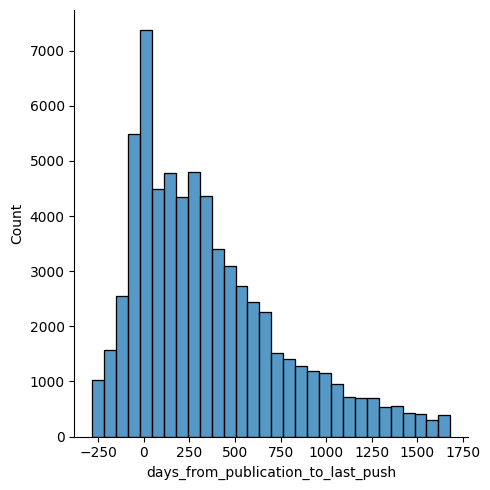

In [72]:
# Create a "days_since_last_push" column
team_composition["days_from_publication_to_last_push"] = (
    team_composition["repository_last_push_datetime"] - team_composition["publication_date"]
).dt.days

# Create copy of dataframe to filter out outliers
team_comp_for_dist = team_composition.copy()

# Filter out outliers
team_comp_for_dist = team_comp_for_dist[
    team_comp_for_dist["days_from_publication_to_last_push"].between(
        team_comp_for_dist["days_from_publication_to_last_push"].quantile(0.03),
        team_comp_for_dist["days_from_publication_to_last_push"].quantile(0.97),
    )
]

# Plot distribution of days since last push
import seaborn as sns

sns.displot(
    team_comp_for_dist,
    x="days_from_publication_to_last_push",
    bins=30,
)

In [73]:
team_comp_for_dist["days_from_publication_to_last_push"].describe()

count    66925.000000
mean       357.020202
std        410.412902
min       -282.000000
25%         30.000000
50%        269.000000
75%        573.000000
max       1681.000000
Name: days_from_publication_to_last_push, dtype: float64

In [83]:
def compute_models(
    y_col: str,
    data: pd.DataFrame,
    glm_family: sm.families.Family,
) -> dict[str, sm.GLM]:
    # Remove outliers
    no_outliers = data[
        data[y_col].between(
            data[y_col].quantile(0.03),
            data[y_col].quantile(0.97),
        )
    ].copy()

    # Remove nans
    no_outliers = no_outliers.dropna(subset=[y_col])

    print(no_outliers[y_col].describe())

    # Common features to use in all models
    required_features = [
        y_col,
        "n_authors",
        "n_author_devs",
        # "pct_authors_contributing_code",
        "years_since_publication",
    ]

    # Iter over different control variables and create models for each
    models = {}
    for control_var in [
        "article_type",
        "domain",
        "is_open_access",
    ]:
        # Get control variable list
        control_variables = [
            col for col in no_outliers.columns if col.startswith(control_var)
        ]

        # Create control variable subset of the data
        control_var_subset = no_outliers[required_features + control_variables].copy()

        # Create interactions
        for coding_status_col in ["n_author_devs"]:
            for control_col in control_variables:
                control_var_subset[f"{coding_status_col} * {control_col}"] = (
                    control_var_subset[coding_status_col]
                    * control_var_subset[control_col]
                )

        # Drop inf and nan
        control_var_subset = control_var_subset.replace(
            [float("inf"), -float("inf")], float("nan")
        ).dropna()

        # Create x and y
        y = control_var_subset[y_col]
        x = control_var_subset.drop(columns=[y_col])
        x = sm.add_constant(x)

        # Fit model
        model = sm.GLM(y, x, family=glm_family).fit()
        models[control_var] = model

    return models

In [84]:
# Create a "days_since_last_push" column
team_composition["days_from_publication_to_last_push"] = (
    team_composition["repository_last_push_datetime"] - team_composition["publication_date"]
).dt.days

team_comp_no_push_after_pub = team_composition.loc[
    team_composition["days_from_publication_to_last_push"] <= 90
]

# Add dummies
team_comp_no_push_after_pub_dummies = pd.get_dummies(
    team_comp_no_push_after_pub,
    columns=["article_type", "domain"],
    drop_first=True,
)

# Drop datetime columns
team_comp_no_push_after_pub_dummies = team_comp_no_push_after_pub_dummies.drop(
    columns=[
        "publication_date",
        "repository_last_push_datetime",
        "days_from_publication_to_last_push",
        "n_devs",
    ]
)

# Cast all to float
team_comp_no_push_after_pub_dummies = team_comp_no_push_after_pub_dummies.astype(float)

cited_by_count_models = compute_models(
    "cited_by_count",
    team_comp_no_push_after_pub_dummies,
    glm_family=sm.families.NegativeBinomial(),
)
cited_by_count_models["is_open_access"].summary()

/Users/evamaxfield/micromamba/envs/rs-graph/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


count    22649.000000
mean        13.439004
std         18.664143
min          1.000000
25%          2.000000
50%          6.000000
75%         16.000000
max        116.000000
Name: cited_by_count, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         cited_by_count   No. Observations:                22649
Model:                            GLM   Df Residuals:                    22643
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78507.
Date:                Wed, 20 Nov 2024   Deviance:                       22924.
Time:                        12:00:57   Pearson chi2:                 3.47e+04
No. Iterations:                    34   Pseudo R-squ. (CS):             0.2857
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.8682      0.059     14.752      0.000       0.753       0.984
n_authors                          0.0219      0.001     20.743      0.000       0.020       0.024
n_author_devs                      0.0575      0.046      1.250      0.211      -0.033       0.148
years_since_publication            0.3750      0.004     93.201      0.000       0.367       0.383
is_open_access                     0.4322      0.060      7.208      0.000       0.315       0.550
n_author_devs * is_open_access    -0.0326      0.047     -0.692      0.489      -0.125       0.060
==================================================================================================
"""

In [85]:
cited_by_count_models["domain"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         cited_by_count   No. Observations:                22649
Model:                            GLM   Df Residuals:                    22639
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78483.
Date:                Wed, 20 Nov 2024   Deviance:                       22877.
Time:                        12:00:57   Pearson chi2:                 3.44e+04
No. Iterations:                    36   Pseudo R-squ. (CS):             0.2872
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        1.1377      0.057     20.100      0.000       1.027       1.249
n_authors                                    0.0230      0.001     21.690      0.000       0.021       0.025
n_author_devs                                0.0735      0.047      1.580      0.114      -0.018       0.165
years_since_publication                      0.3903      0.004     97.613      0.000       0.383       0.398
domain_Life Sciences                        -0.1961      0.067     -2.937      0.003      -0.327      -0.065
domain_Physical Sciences                     0.1537      0.056      2.722      0.006       0.043       0.264
domain_Social Sciences                      -0.2158      0.075     -2.892      0.004      -0.362      -0.070
n_author_devs * domain_Life Sciences         0.0143      0.055      0.261      0.794      -0.093       0.122
n_author_devs * domain_Physical Sciences    -0.0624      0.048     -1.307      0.191      -0.156       0.031
n_author_devs * domain_Social Sciences       0.0538      0.060      0.889      0.374      -0.065       0.172
============================================================================================================
"""

In [86]:
import numpy as np
np.exp(-0.5064)

0.602661258781

In [87]:
cited_by_count_models["article_type"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         cited_by_count   No. Observations:                22649
Model:                            GLM   Df Residuals:                    22641
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78130.
Date:                Wed, 20 Nov 2024   Deviance:                       22169.
Time:                        12:00:58   Pearson chi2:                 3.37e+04
No. Iterations:                    34   Pseudo R-squ. (CS):             0.3091
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.7721      0.035     21.939      0.000       0.703       0.841
n_authors                                         0.0213      0.001     20.157      0.000       0.019       0.023
n_author_devs                                    -0.0458      0.024     -1.894      0.058      -0.093       0.002
years_since_publication                           0.3956      0.004     99.544      0.000       0.388       0.403
article_type_research article                     0.5032      0.035     14.196      0.000       0.434       0.573
article_type_software article                    -0.5197      0.116     -4.475      0.000      -0.747      -0.292
n_author_devs * article_type_research article     0.0954      0.026      3.599      0.000       0.043       0.147
n_author_devs * article_type_software article     0.0697      0.058      1.210      0.226      -0.043       0.183
=================================================================================================================
"""

- To enrich our pre-existing dataset, we apply our trained predictive model across pairs of authors and developer accounts.
	- again, these pairs are all combinations of author and developer account within an individual paper
	- specifics, how many unique author-developer account pairs are we able to find
	- table of author-developer account pairs for by data source / by field
	- we next use this enriched dataset to understand software development dynamics within research teams, and characterize the authors who are and who aren’t code contributors.

## Software Development Dynamics Within Research Teams

- We begin by measuring the distributions of different coding and non-coding contributors across all of the article-code-repository pairs within our dataset.
	- explain more, what are the different types of contributions? (coding contributor, coding-with-authorship contributor, non-coding-author, etc.)
	- what are the basics / what do we see across the board? What are the distributions of each of these contributor types
	- compare against analysis built on CRediT statements?

- Next we investigate if these distributions change over time, or, by “research team size”.
	- define research team size, in our case this is the total number of author-developers + non-coding authors + non-credited developers
	- plot the medians of the contributor type distributions over time (by publication year)
	- create subplots of different bins of research team size (i.e. <= 3 members, >3 <= 5, >5 <= 10, >10) and show distributions again.
	- results in summary

- We further investigate how these distributions are affected by article type and research domain.
	- refresher on article type (research articles, software articles, and pre-prints)
	- explain research domains
	- subplots of both
	- results in summary

## Characteristics of Scientific Code Contributors

- Next we investigate the differences between coding and non-coding article authors.
	- specifics, author position in authorship list is a commonly used tool in scientometrics
	- similarly, metrics of “scientific impact” such as h-index, i10 index, and two-year mean citedness are also available to us.
	- plot / table of the distributions between coding and non-coding authors
	- ANOVA / Chi2 tests to see if these differences are significant
	- results in summary

- Just as before, we next investigate if these results are affected by article type and research domain.
	- subplot + stats tests for differences by each article type
	- subplot + stats tests for differences by each domain
	- results in summary

# Discussion